In [ ]:
# Voeg imports toe als je ze nodig hebt
import torch.nn as nn
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import ToTensor
import torch
import torchvision.io as tio
import matplotlib.pyplot as plt

%matplotlib inline


In [ ]:
mylearnrate = 0.001
batchsize = 32
mymomentum = 0.9
epochs = 500
optchoice = 'sgd'
generator1 = torch.Generator().manual_seed(42)
inputdata = 'resized128' # choose cropped, resized128, resized224


In [ ]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


Using cuda device


In [ ]:
if inputdata == 'cropped':
    dataset_path = "./apple_cropped"
elif inputdata == 'resized128':
    dataset_path = "./apple_resized_128/Train"
elif inputdata == 'resized224':
    dataset_path = './apple_resized_224/Train'
print(dataset_path)

./apple_resized_128/Train


In [ ]:
# get length of each folder in imagefolder dataset

import os

imagefolder = dataset_path

for folder in os.listdir(imagefolder):
    print(folder, len(os.listdir(os.path.join(imagefolder, folder))))


Blotch_Apple 115
Normal_Apple 67
Rot_Apple 114
Scab_Apple 85


In [ ]:

#If our dataset is more similar to ImageNet dataset, we can use ImageNet mean and std. ImageNet mean and std are mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]

from torchvision import transforms

# https://towardsdatascience.com/data-augmentations-in-torchvision-5d56d70c372e
transform_img_normal = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize(mean = [0.5125,0.4667,0.4110],
    #                      std= [0.2621,0.2501,0.2453]),
    # transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomVerticalFlip(p=0.5),
    # transforms.RandomRotation(45),
    #transforms.Grayscale(3) #expected is 3 channels for the model, r == g == b
])

dataset = ImageFolder(dataset_path, transform=transform_img_normal)


In [ ]:
dataset.class_to_idx


{'Blotch_Apple': 0, 'Normal_Apple': 1, 'Rot_Apple': 2, 'Scab_Apple': 3}

In [ ]:
# split in train and test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size],generator=generator1)


In [ ]:
trainloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batchsize, shuffle=True, num_workers=2)  # numworkers parallel/subprocesses
testloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batchsize, shuffle=False)  # no need to shuffle when evaluating


In [ ]:
dataset_path_test = "./apple_resized/Test"
transform = ToTensor()
dataset_test = ImageFolder(dataset_path, transform=transform)
dataset_test_loader = torch.utils.data.DataLoader(
    dataset_test, batch_size=32, shuffle=False)


In [ ]:
resnetmodel = torch.hub.load(
    "pytorch/vision", "resnet18", weights="IMAGENET1K_V1")
num_ftrs = resnetmodel.fc.in_features

# Here the size of each output sample is set to 4
resnetmodel.fc = nn.Linear(num_ftrs, 4)

# Check if output size is correct
resnetmodel.eval()


Using cache found in C:\Users\tinke/.cache\torch\hub\pytorch_vision_main


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# load to CUDA
myresnetmodel = resnetmodel.to(device)

In [ ]:
import torch.optim as optim
CrossEntropyLossCriterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(myresnetmodel.parameters(), lr=mylearnrate, momentum=mymomentum)
if optchoice == 'adam':
    optimizer = optim.Adam(myresnetmodel.parameters(), lr=mylearnrate)
    print('optimizer = Adam')
elif optchoice  == 'sgd':
    optimizer = optim.SGD(myresnetmodel.parameters(), lr=mylearnrate, momentum=mymomentum)
    print('optimizer = sgd')

optimizer = sgd


<Figure size 640x480 with 0 Axes>

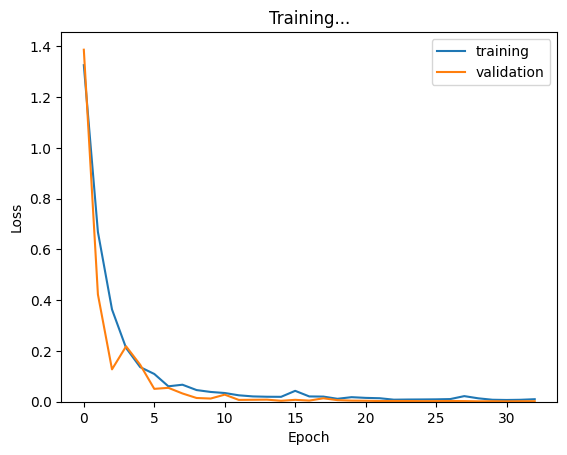

Early stopping


In [ ]:
# Train function

import realtime_graph as graph
import gc

epochresults = []
epoch_valloss = 0 
graph.startplot()


for epoch in range(epochs):
    
    running_loss = 0.0
    running_valloss = 0.0

    myresnetmodel.train()
    for idx, data in enumerate(trainloader):
        inputs, labels = data
        # print(inputs.shape) = torch.Size([4, 3, 32, 32])

        #---load data into GPU----
        inputs = inputs.to(device)
        labels = labels.to(device)
        #-------------------------
        
        #forward pass
        outputs = myresnetmodel.forward(inputs)
        loss = CrossEntropyLossCriterion(outputs, labels)

        optimizer.zero_grad()  # reset previous calculated loss gradients to zero
        loss.backward() # calculate new loss gradient

        optimizer.step() # update weights based on learning rate and gradients
        running_loss += loss.item()

    epoch_loss = running_loss / len(trainloader)

    myresnetmodel.eval() # prep model for evaluation
    epoch_vallos_previous = epoch_valloss
    for idx, data in enumerate(testloader):
        #forward pass
        outputs = myresnetmodel.forward(inputs)
        loss = CrossEntropyLossCriterion(outputs, labels)

        optimizer.zero_grad()  # reset previous calculated loss gradients to zero
        loss.backward() # calculate new loss gradient

        # record validation loss
        running_valloss += loss.item()
        

    epoch_valloss = running_valloss / len(testloader)


    epochresults.append([epoch_loss, epoch_valloss])

    
    graph.realtimeplot(epochresults)

    limit = 0.0001    
    if epoch_vallos_previous-limit < epoch_valloss < epoch_vallos_previous+limit and epoch_loss<0.05:
        print("Early stopping")
        break

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

correct = 0
total = 0
confusion_matrix = np.zeros((4, 4))  # Initialize the confusion matrix

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for idx, data in enumerate(dataset_test_loader):
        inputs, labels = data
        # print(inputs.shape) = torch.Size([4, 3, 32, 32])

        # ---load data into GPU----
        inputs = inputs.to(device)
        labels = labels.to(device)
        # -------------------------

        # calculate outputs by running images through the network
        outputs = myresnetmodel.forward(inputs)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Update confusion matrix
        for i in range(len(labels)):
            confusion_matrix[labels[i]][predicted[i]] += 1

print(f'Accuracy of the network on the test images: {100 * correct // total} %')
print('Confusion Matrix:')
print(confusion_matrix)

Accuracy of the network on the test images: 98 %
Confusion Matrix:
[[115.   0.   0.   0.]
 [  0.  66.   0.   1.]
 [  0.   1. 113.   0.]
 [  2.   0.   1.  82.]]


In [ ]:
# >>> from torchmetrics.classification import MulticlassConfusionMatrix
# >>> target = torch.tensor([2, 1, 0, 0])
# >>> preds = torch.tensor([
# ...   [0.16, 0.26, 0.58],
# ...   [0.22, 0.61, 0.17],
# ...   [0.71, 0.09, 0.20],
# ...   [0.05, 0.82, 0.13],
# ... ])
# >>> metric = MulticlassConfusionMatrix(num_classes=3)
# >>> metric(preds, target)
# tensor([[1, 1, 0],
#         [0, 1, 0],
#         [0, 0, 1]])